In [1]:
!pip install rdkit


In [2]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, AllChem
from rdkit.Chem.Draw import IPythonConsole

from itertools import combinations

import IPython
from IPython.display import display, Image
from PIL import Image

import numpy as np
import pandas as pd

import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv(r"C:\Users\USER\Desktop\proteinler\SMILES_Big_Data_Set.csv")

In [4]:
df.head(5)

,SMILES,pIC50,mol,num_atoms,logP
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,<rdkit.Chem.rdchem.Mol object at 0x7f59df45bc30>,25,4.1591
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c9e0>,36,3.6743
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cac0>,23,1.5361
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cba0>,22,0.9510
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c7b0>,21,3.2130


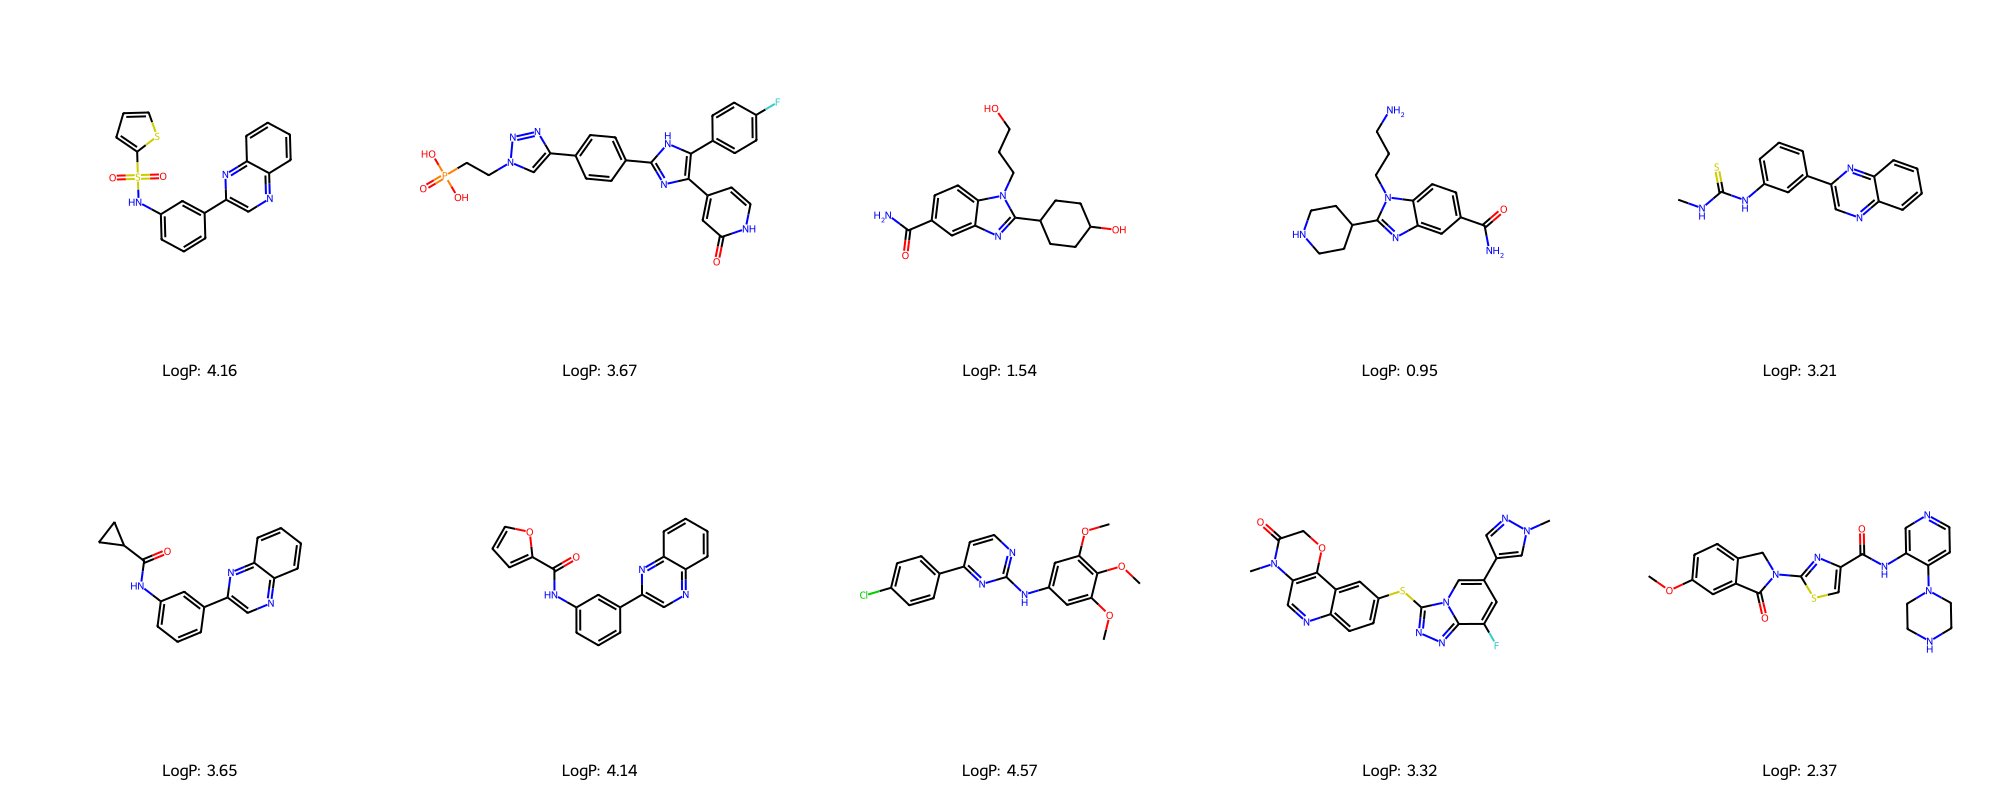

In [5]:
def show_smiles(smiles):
  """
 Moleküllerin 2 boyutlu temsillerini oluşturup ve bunları logP ile renk kodlanması.

  """
  
# SMILES dizelerini RDKit moleküllerine dönüştürme 
  molecules = [Chem.MolFromSmiles(smile) for smile in smiles]

  # İlk molekülleri çizimi
  img = Draw.MolsToGridImage(molecules[:10], molsPerRow=5, subImgSize=(400,400),
                             legends=[f'LogP: {round(x, 2)}' for x in df['logP']], 
                             returnPNG=False).save("molecules.png")
                             
  from IPython.display import display, Image
  
  display(Image("molecules.png"))

show_smiles(df["SMILES"])

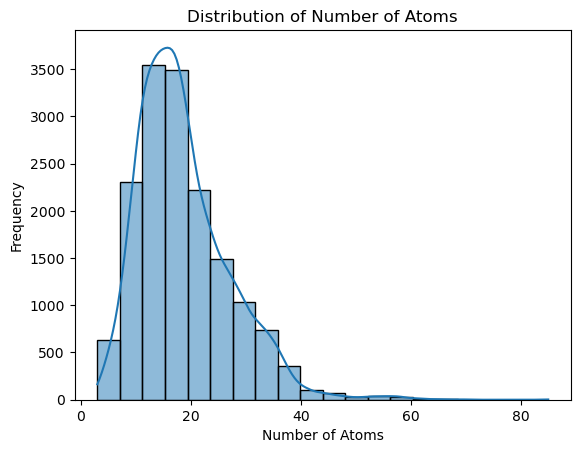

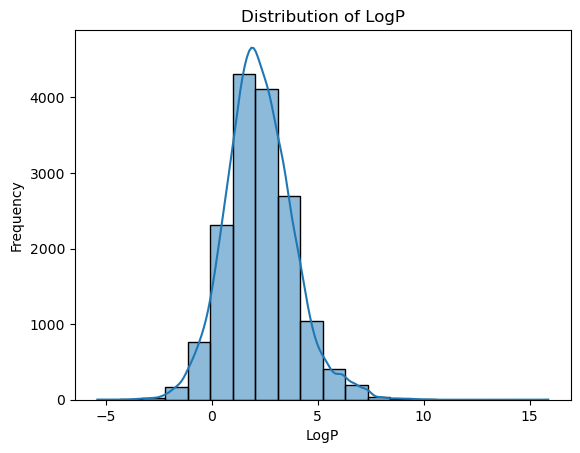

In [6]:
def histogram_of_distribution(data_frame):
  """
Atom Sayısının dağılımını ve LogP Dağılımını görselleştirmesi
  
  """
  sns.histplot(data=df, x='num_atoms', bins=20, kde=True)
  plt.title('Distribution of Number of Atoms')
  plt.xlabel('Number of Atoms')
  plt.ylabel('Frequency')
  plt.show()

  sns.histplot(data=df, x='logP', bins=20, kde=True)
  plt.title('Distribution of LogP')
  plt.xlabel('LogP')
  plt.ylabel('Frequency')
  plt.show()

histogram_of_distribution(df)

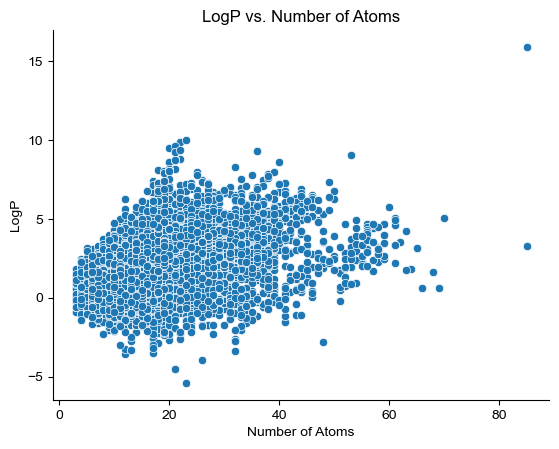

In [7]:
def num_atoms_and_logP(data_frame):
  """
logP ile atom sayısı arasındaki ilişkiyi çizimi
  """
  sns.scatterplot(data=data_frame, x='num_atoms', y='logP')
  sns.despine()
  sns.set_style("whitegrid")
  plt.title('LogP vs. Number of Atoms')
  plt.xlabel('Number of Atoms')
  plt.ylabel('LogP')
  plt.show()

num_atoms_and_logP(df)

In [8]:
html_code = \
'''
<p>This is a 3D object you can interact with it!</p>
<iframe style="width: 900px; height: 900px;" frameborder="0" src="https://embed.molview.org/v1/?mode=balls&cid=127055553"></iframe>
'''
display(IPython.display.HTML(html_code))

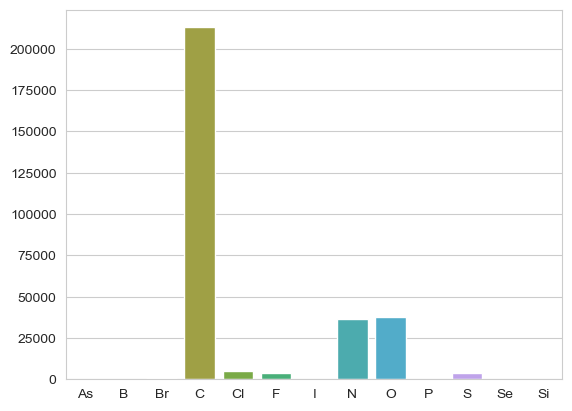

In [9]:
def atom_frequency(smiles_list):
    """
SMILES'taki farklı atom türlerinin frekansı :param smiles_list: SMILES dizelerinin listesi
    """
    atom_counts = []
    for smiles in smiles_list:
        # SMILES dizesini bir RDKit molekül nesnesine dönüştürün
        mol = Chem.MolFromSmiles(smiles)
        # Moleküldeki atomları alınması
        atoms = mol.GetAtoms()
        # Her atomun sembolünü atom_counts listesine ekleyin
        atom_counts.extend([atom.GetSymbol() for atom in atoms])

    # Her atom tipinin sayısını içeren bir pandas serisi oluşturma
    plot_data = pd.Series(atom_counts).value_counts().sort_index()
    sns.barplot(x=plot_data.index, y=plot_data.values)

atom_frequency(df['SMILES'])

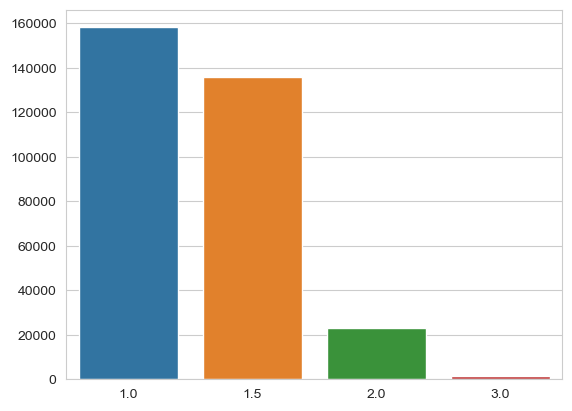

In [10]:
def bond_frequency(smiles_list):
    """
 Farklı bağ türlerinin sıklığı:param smiles_list: SMILES dizelerinin listesi
    """
    bond_counts = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        bonds = mol.GetBonds()
        # Moleküldeki her bir bağ üzerinde döngü yaptıktan sonra   bağ tipini bond_counts listesine ekleyin
        bond_counts.extend([bond.GetBondTypeAsDouble() for bond in bonds])
    #Her bağ türünün sıklığını sayıp  sayıları artan sırada sıralamak
    plot_data = pd.Series(bond_counts).value_counts().sort_index()
    sns.barplot(x=plot_data.index, y=plot_data.values)

bond_frequency(df['SMILES'])

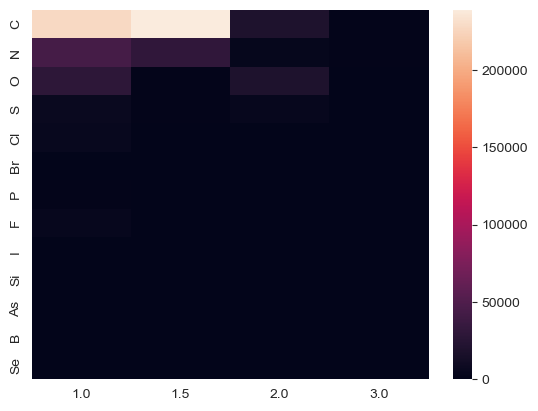

In [11]:
def atom_bond_heatmap(smiles_list):
    """
    Farklı atom ve bağ türlerinin ikili oluşumları:param smiles_list: SMILES dizelerinin listesi
    """
    # Dikkate alınacak atom ve bağ türlerini tanımlamak
    atom_types = ['C', 'N', 'O', 'S', 'Cl', 'Br', 'P', 'F', 'I', 'Si', 'As', 'B', 'Se']
    bond_types = [1.0, 1.5, 2.0, 3.0]
    # Verileri sıfırlarla başlatmak
    data = np.zeros((len(atom_types), len(bond_types)))
    for smiles in smiles_list:
        # SMILES dizgesini molekül nesnesine dönüştürmek
        mol = Chem.MolFromSmiles(smiles)
        # Moleküldeki atomları ve bağları almak
        atoms = mol.GetAtoms()
        bonds = mol.GetBonds()
        # Moleküldeki atomları ve bağları almak
        for bond in bonds:
            # Bağ türünü ve bond_types listesindeki indeksini almak
            bond_type = bond.GetBondTypeAsDouble()
            bond_idx = bond_types.index(bond_type)
            # Bağdaki her atom için data dizisini güncellemek
            for atom in [bond.GetBeginAtom(), bond.GetEndAtom()]:
                # Atom türünü ve atom_types listesindeki indeksini almak
                atom_type = atom.GetSymbol()
                atom_idx = atom_types.index(atom_type)
                # Atom-bağ çifti için data dizisindeki sayımı artırmak
                data[atom_idx, bond_idx] += 1
    sns.heatmap(data, xticklabels=bond_types, yticklabels=atom_types)

atom_bond_heatmap(df["SMILES"])


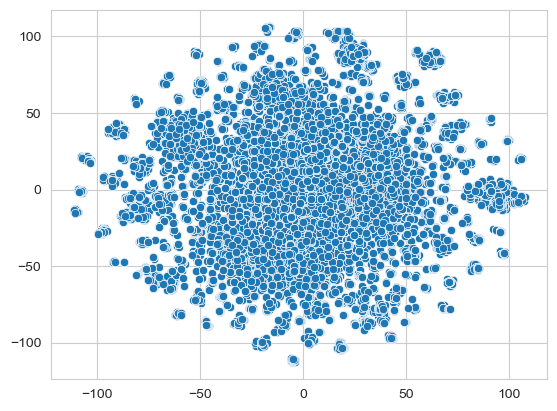

In [12]:
def fingerprint_tsne(smiles_list):
    """
    Bir dizi SMILES dizesi için moleküler parmak izlerinin t-SNE grafiğini çizmek
    :param smiles_list: SMILES dizelerinin listesi
    """
    from sklearn.manifold import TSNE
    from rdkit.Chem import AllChem
    # Morgan algoritmasını kullanarak moleküler parmak izlerini oluşturmak (radius=2 ile)
    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles),
                                                 2) for smiles in smiles_list]
    # Parmak izleri listesini bir numpy dizisine dönüştürmek
    fps_array = np.asarray(fps)
    tsne = TSNE(n_components=2)
    tsne_result = tsne.fit_transform(fps_array)
    sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1])

fingerprint_tsne(df['SMILES'])


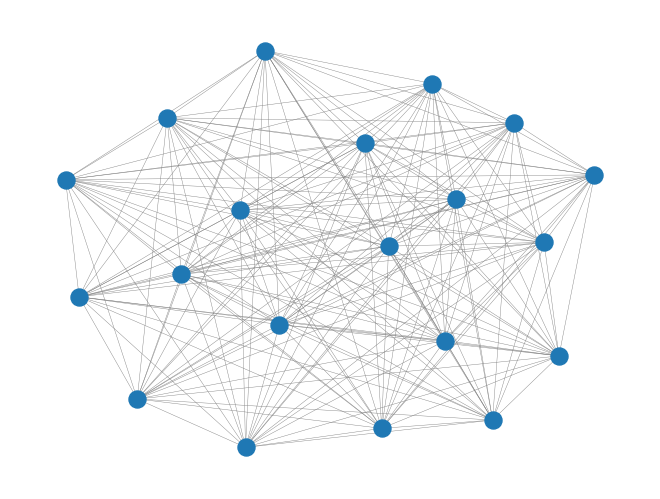

In [13]:
def molecular_similarity(smiles_list):
  # Morgan algoritmasını kullanarak moleküler parmak izlerini oluşturmak (radius=2 ile)
  fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2) for smiles in smiles_list]

  # Çiftler arası benzerlik skorlarını *(Tanimoto benzerlik katsayısı kullanarak) hesaplamak
  similarity_scores = []
  for fp1, fp2 in combinations(fps, 2):
      similarity_score = DataStructs.TanimotoSimilarity(fp1, fp2)
      similarity_scores.append(similarity_score)

  # NetworkX kullanarak bir benzerlik ağı oluşturmak
  G = nx.Graph()
  for idx, smiles in enumerate(smiles_list):
      G.add_node(idx, smiles=smiles)
  for (i, j), weight in zip(combinations(range(len(smiles_list)), 2), similarity_scores):
      G.add_edge(i, j, weight=weight)

  # Ağı görselleştirmek
  pos = nx.spring_layout(G)
  nx.draw(G, pos=pos, node_size=150, width=0.3, edge_color='gray', with_labels=False)
  plt.show()

short_df_for_grahp = df.head(20)
molecular_similarity(short_df_for_grahp["SMILES"])


In [14]:
!pip install tensorflow


{'Moleküler Ağırlık': 180.15899999999996, 'LogP': 1.3101, 'H-Bond Donör Sayısı': 1, 'H-Bond Alıcı Sayısı': 3}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Model Output: [[20.779196  -9.75187   -1.8140396]]
Reconstructed SMILES: CC(=O)Oc1ccccc1C(=O)O


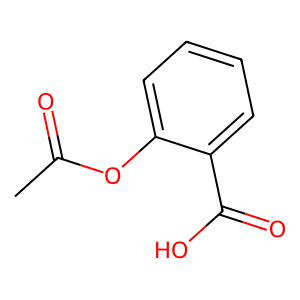

In [16]:
import re
import random

import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import MolToImage

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


class DRLAgent:
    """
  
        state_size (int): Durum uzayının boyutu
        action_size (int): Eylem uzayının boyutu
    """

    def __init__(self, state_size, action_size, selected_X_train):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        # indirim oranı
        self.gamma = 0.95#indirim faktörü
        # keşif oranı
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.selected_X_train = selected_X_train
        self.model = self._build_model(selected_X_train)
        # kararlılık için hedef model
        self.target_model = self._build_model(selected_X_train) 
        self.update_target_model()

    def _build_model(self, selected_X_train):
        """
      

        
            model (Sequential): Derin Q-Ağı modeli
        """
        model = Sequential()
        model.add(Dense(32, input_shape=(selected_X_train.shape[1],), activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        """Hedef model ağırlıklarını güncel model ağırlıkları ile güncelle"""
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """
    
            state (ndarray): Mevcut durum
            action (int): Yapılan eylem
            reward (float): Alınan ödül
            next_state (ndarray): Sonraki durum
            done (bool): Bölümün bitip bitmediği
        """
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """
     
            state (ndarray): Mevcut durum

      
            action (int): Seçilen eylem
        """
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        if state is None:
            state = np.zeros((1, self.state_size))
        else:
            state = state.reshape(1, self.state_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        """
       
            batch_size (int): Minibatch boyutu
        """
        # Tekrar oynatma hafızasından bir minibatch deneyimi örnekle
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            if state is not None:
                if not done:
                    # Hedef değeri hedef modeli kullanarak hesapla
                    target = (reward + self.gamma * np.amax(self.target_model.predict(next_state)[0]))
                else:
                    target = reward
                # Ajanın mevcut durumu gelecekteki indirilmiş ödüle yaklaşık olarak eşlemesini sağla
                target_f = self.model.predict(state)
                target_f[0][action] = target
                # Mevcut durumu ve hedef değeri kullanarak modeli eğit
                self.model.fit(state, target_f, epochs=1, verbose=0)
        # Keşif oranını azalt
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        """Model ağırlıklarını bir dosyadan yükle"""
        self.model.load_weights(name)

    def save(self, name):
        """Model ağırlıklarını bir dosyaya kaydet"""
        self.model.save_weights(name)


def preprocess_smiles(smiles):
    """
  
        smiles (str): SMILES dizgesi

  
        preprocessed_smiles (str): İşlenmiş SMILES dizgesi
    """
    # Tuzları kaldır
    preprocessed_smiles = re.sub(r'\[.*?\]', '', smiles)
    # Stereokimya bilgilerini kaldır
    preprocessed_smiles = re.sub(r'[@]\S*', '', preprocessed_smiles)
    return preprocessed_smiles


def calculate_molecular_properties(smiles):
    """
  
        smiles (str): SMILES dizgesi

   
        properties (dict): Moleküler özelliklerin sözlüğü
    """
    molecule = Chem.MolFromSmiles(smiles)
    properties = {}

    if molecule is not None:
        properties['Moleküler Ağırlık'] = Descriptors.MolWt(molecule)
        properties['LogP'] = Descriptors.MolLogP(molecule)
        properties['H-Bond Donör Sayısı'] = Descriptors.NumHDonors(molecule)
        properties['H-Bond Alıcı Sayısı'] = Descriptors.NumHAcceptors(molecule)

    return properties


if __name__ == '__main__':
    smiles = 'CC(=O)OC1=CC=CC=C1C(=O)O'
    #CC(=O)OC1=CC=CC=C1C(=O)O
    preprocessed_smiles = preprocess_smiles(smiles)
    properties = calculate_molecular_properties(preprocessed_smiles)
    print(properties) # {'Moleküler Ağırlık': 180.15899999999996, 'LogP': 1.3101, 'H-Bond Donör Sayısı': 1, 'H-Bond Alıcı Sayısı': 3}
    
    # properties sözlüğünü bir NumPy dizisine dönüştür
    selected_X_train = np.array(list(properties.values())).reshape(1, -1)

    agent = DRLAgent(state_size=selected_X_train.shape[1], action_size=3, selected_X_train=selected_X_train)

    # Seçilen giriş için modelin çıktısını al
    output = agent.model.predict(selected_X_train)
    print("Model Output:", output)

    # Modelle işlendikten sonra molekülün SMILES temsilini elde et
    reconstructed_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(preprocessed_smiles))
    print("Reconstructed SMILES:", reconstructed_smiles)
    
    mol = Chem.MolFromSmiles(reconstructed_smiles)
    if mol is None:
        print(f"SMILES'tan molekül oluşturulurken hata: {reconstructed_smiles}")
    else:
        display(MolToImage(mol))


In [ ]:
import re
import random

import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import MolToImage

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


class DRLAgent:
    """
    Derin Pekiştirmeli Öğrenme Ajanı

    Args:
        state_size (int): Durum alanının boyutu
        action_size (int): Aksiyon alanının boyutu
    """

    def __init__(self, state_size, action_size, selected_X_train, num_actions):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        # indirim oranı
        self.gamma = 0.95
        # keşif oranı
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.selected_X_train = selected_X_train
        self.model = self._build_model(selected_X_train)
        # stabilite için hedef model
        self.target_model = self._build_model(selected_X_train)
        self.update_target_model()
        self.num_actions = num_actions 

    def _build_model(self, selected_X_train):
        """
        Derin Q-Ağı modelini oluştur

        Returns:
            model (Sequential): Derin Q-Ağı modeli
        """
        model = Sequential()
        model.add(Dense(32, input_shape=(selected_X_train.shape[1],), activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        # model.add(Dense(num_actions, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        """Hedef model ağırlıklarını mevcut model ağırlıkları ile güncelle"""
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """
        Deneyimi tekrar oynatma belleğine kaydet

        Args:
            state (ndarray): Mevcut durum
            action (int): Yapılan aksiyon
            reward (float): Alınan ödül
            next_state (ndarray): Bir sonraki durum
            done (bool): Bölümün bitip bitmediği
        """
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """
        Mevcut duruma göre bir aksiyon seç

        Args:
            state (ndarray): Mevcut durum

        Returns:
            action (int): Seçilen aksiyon
        """
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        if state is None:
            state = np.zeros((1, self.state_size))
        else:
            state = state.reshape(1, self.state_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        """
        Deneyimleri tekrar oynatarak modeli eğit

        Args:
            batch_size (int): Minibatch boyutu
        """
        # Deneyimlerin minibatch örneğini tekrar oynatma belleğinden al
        minibatch = random.sample(self.memory, batch_size)
        agent.model.compile(loss='mean_squared_error', optimizer='adam') 
        # print(f'minibatch {minibatch}')
        for state, action, reward, next_state, done in minibatch:
            if state is not None:
                # target = np.reshape(target, (batch_size, self.num_actions))
                target = np.zeros((batch_size, num_actions)) 
                if not done:
                    # Hedef değeri hedef modeli kullanarak hesapla
                    target = (reward + self.gamma * np.amax(
                        self.target_model.predict(next_state.reshape(1, self.state_size))[0]))
                # Mevcut durum için tahmin edilen Q-değerlerini al
                target_f = self.model.predict(state.reshape(1, self.state_size))
                # print(f'target_f: {target_f}')
                # Seçilen aksiyon için hedef Q-değerini güncelle
                target_f[0][action] = target
                # Güncellenmiş hedef Q-değeri ile modeli güncelle
                self.model.fit(state.reshape(1, self.state_size), target_f, epochs=1, verbose=0)

        # Keşif oranını azalt
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        """
        Model ağırlıklarını bir dosyadan yükle

        Args:
            name (str): Dosyanın adı
        """
        self.model.load_weights(name)

    def save(self, name):
        """
        Model ağırlıklarını bir dosyaya kaydet

        Args:
            name (str): Dosyanın adı
        """
        self.model.save_weights(name)


class DrugDesignEnv:
    """
    İlaç Tasarım Ortamı

    Args:
        num_features (int): Her molekül için özellik sayısı
        num_actions (int): Seçilebilecek aksiyonların (moleküllerin) sayısı
        X_train (list): Eğitim için ön işlenmiş SMILES stringlerinin listesi
        y_train (ndarray): Eğitim için karşılık gelen hedef değerlerin dizisi
    """
    def __init__(self, num_features, num_actions, X_train, y_train):
        self.num_features = num_features
        self.num_actions = num_actions
        self.current_state = np.zeros((num_features,))
        self.reward = 0
        # ajanının eşleştirmeye veya yaklaştırmaya çalıştığı bir hedef vektörü veya deseni temsil eder
        self.target = np.ones((self.num_features,))
        self.max_steps = 10
        self.step_count = 0
        self.generated_smiles = []
        self.X_train = X_train
        self.y_train = y_train

    def _get_reward(self):
        """Mevcut durum ile hedef arasındaki benzerliğe dayalı ödülü hesapla"""
        similarity = np.dot(self.current_state, self.target)
        return similarity / self.num_actions
        
    def _is_done(self):
        """Maksimum adım sayısının ulaşılıp ulaşılmadığını kontrol et"""
        self.step_count += 1
        return self.step_count >= self.max_steps

    def get_smiles(self):
        """Mevcut durumun SMILES string gösterimini döndür."""
        binary_string = ''.join([str(int(x)) for x in self.current_state])
        return binary_string


    def step(self, action):
        """
        Ortamda bir adım gerçekleştir

        Args:
            action (int): Ajan tarafından yapılan aksiyon

        Returns:
            Tuple[np.ndarray, float, bool]: Bir sonraki durumu, ödülü ve bitiş bayrağını içeren demet
        """
        # Aksiyonun geçerli aralıkta olduğundan emin ol
        action = max(0, min(action, self.num_actions - 1))
        # Bir sonraki durumu başlat
        next_state = np.zeros((self.num_features,))
        # Bir sonraki durumda seçilen aksiyonu 1 olarak ayarla
        next_state[action] = 1.0
        # Mevcut durumu güncelle
        self.current_state = next_state
        # Mevcut duruma dayalı ödülü hesapla
        reward = self._get_reward()
        # Bölümün bitip bitmediğini kontrol et
        done = self._is_done()
        self.generated_smiles.append(action)
        return self.current_state, reward, done

    def reset(self):
        """Ortamı sıfırla"""
        self.current_state = np.zeros((self.num_features,))
        self.generated_smiles = []
        return self.current_state
